# Neural Network

Episode 0, loss 17425.9980 
Episode 50, loss 10767.1348 
Episode 100, loss 6209.7212 
Episode 150, loss 3335.2615 
Episode 200, loss 1656.5206 
Episode 250, loss 756.5009 
Episode 300, loss 316.5666 
Episode 350, loss 121.3489 
Episode 400, loss 42.8664 
Episode 450, loss 14.2941 
Episode 500, loss 4.8707 
Episode 550, loss 2.0523 
Episode 600, loss 1.2853 
Episode 650, loss 1.0923 
Episode 700, loss 1.0439 
Episode 750, loss 1.0282 
Episode 800, loss 1.0190 
Episode 850, loss 1.0106 
Episode 900, loss 1.0022 
Episode 950, loss 0.9935 


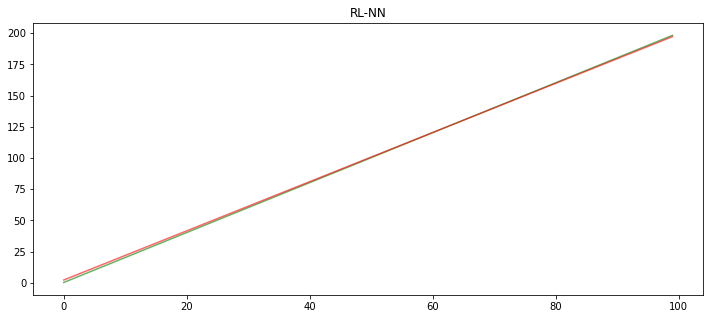

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

Tensor = FloatTensor
learning_rate = 0.01
num_episodes = 1000


W = 2
b = 0.3
x = Variable(torch.arange(100, dtype=torch.float).unsqueeze(1))
y = W * x + b


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(1,1)
    
    def forward(self, x):
        output = self.linear1(x)
        return output

mynn = NeuralNetwork()

if use_cuda:
    mynn.cuda()

loss_func = nn.MSELoss()
#loss_func = nn.SmoothL1Loss()
optimizer = optim.Adam(params=mynn.parameters(), lr=learning_rate)

for i_episode in range(num_episodes):
    predicted_value = mynn(x)
    loss = loss_func(predicted_value, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i_episode % 50 == 0:
        print("Episode %i, loss %.4f " % (i_episode, loss.item()))

plt.figure(figsize=(12,5))
plt.title("RL-NN")
plt.plot(x.data.numpy(), y.data.numpy(), alpha=0.6, color='green')
plt.plot(x.data.numpy(), predicted_value.data.numpy(), alpha=0.6, color='red')

plt.show()

# Random Cart Pole

Average Rewards: 22.556 %
Average Rewards(Last 100 episodes): 20.14 %


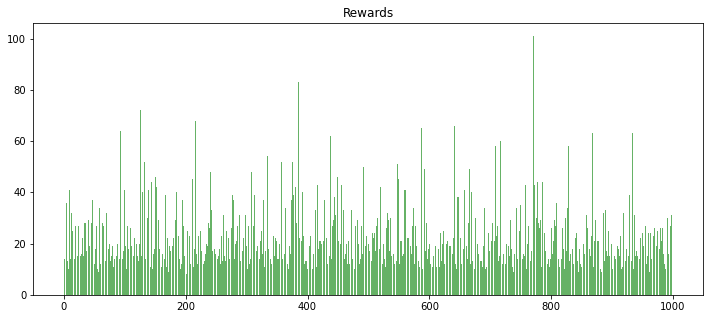

In [72]:
import torch
import gym
import matplotlib.pyplot as plt
import random

env = gym.make('CartPole-v1')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

num_episodes = 1000
steps_total = []

for i_episode in range(num_episodes):
    state = env.reset()
    step = 0
    
    while True:
        step += 1
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        
        if done:
            steps_total.append(step)
            #print('Episode finished after %i steps' % step)
            break

print("Average Rewards: {} %".format(sum(steps_total)/num_episodes))
print("Average Rewards(Last 100 episodes): {} %".format(sum(steps_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.env.close()

<BarContainer object of 3316 artists>

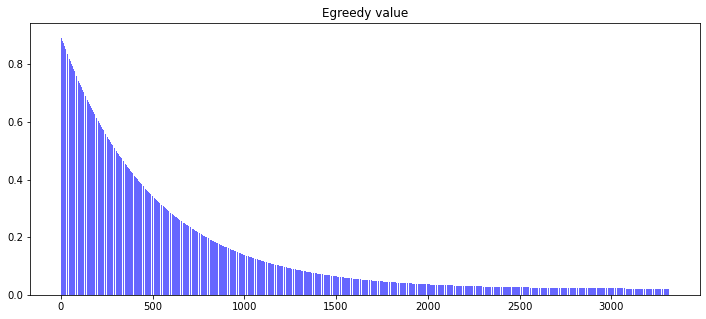

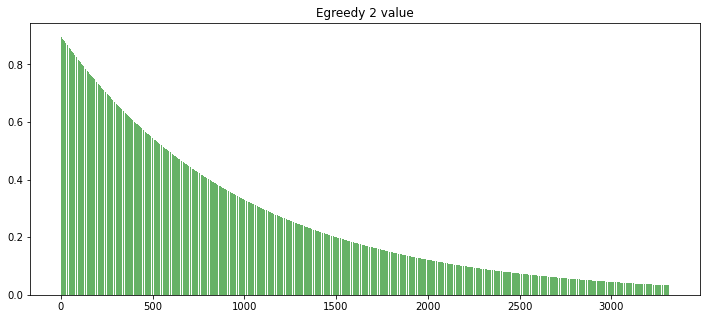

In [73]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: udemy
"""

import torch
import matplotlib.pyplot as plt
import math
import gym

env = gym.make('CartPole-v0')
num_episodes = 150

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

egreedy_prev = egreedy
egreedy_prev_final = egreedy_final
egreedy_prev_decay = 0.999

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

egreedy_total = []
egreedy_prev_total = []

steps_total = 0 

for i_episode in range(num_episodes):

    state = env.reset()
    while True:
        
        steps_total += 1

        epsilon = calculate_epsilon(steps_total)
        egreedy_total.append(epsilon)

        action = env.action_space.sample()

        new_state, reward, done, info = env.step(action)
        
        state = new_state  
        if egreedy_prev > egreedy_prev_final:
            egreedy_prev *= egreedy_prev_decay
            egreedy_prev_total.append(egreedy_prev)
        else:
            egreedy_prev_total.append(egreedy_prev)
            
        if done:
            break
                
plt.figure(figsize=(12,5))
plt.title("Egreedy value")
plt.bar(torch.arange(len(egreedy_total)), egreedy_total, alpha=0.6, color='blue')

plt.figure(figsize=(12,5))
plt.title("Egreedy 2 value")
plt.bar(torch.arange(len(egreedy_prev_total)), egreedy_prev_total, alpha=0.6, color='green')


Average reward: 17.66
Average reward (last 100 episodes): 29.56


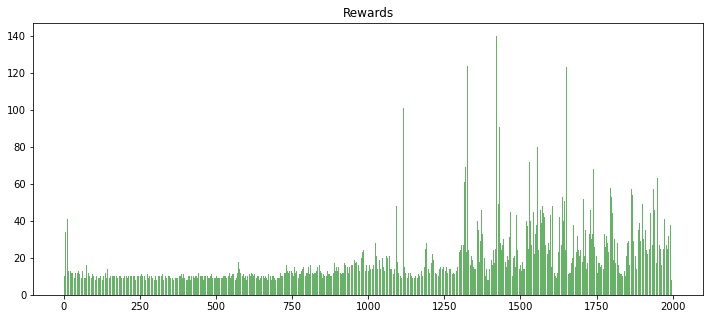

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.01
num_episodes = 2000
gamma = 0.85

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,number_of_outputs)
        
    def forward(self, x):
        output = self.linear1(x)
        return output
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        
        reward = Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()  
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        qnet_agent.optimize(state, action, new_state, reward, done )
        
        state = new_state
        
        if done:
            steps_total.append(step)
            # print("Episode finished after %i steps" % step )
            break
        

print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

Average reward: 19.27
Average reward (last 100 episodes): 30.35


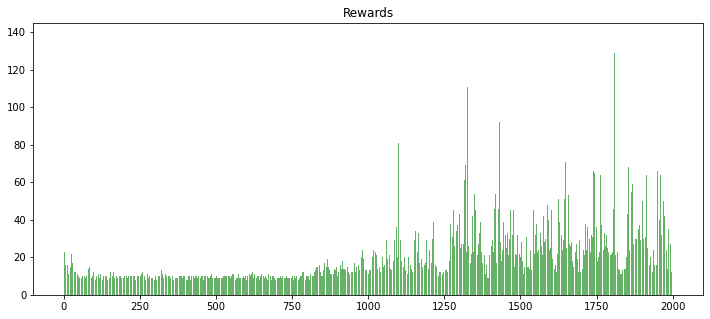

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.01
num_episodes = 2000
gamma = 0.85

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,number_of_outputs)
        
    def forward(self, x):
        output = self.linear1(x)
        return output
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        
        reward = Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        qnet_agent.optimize(state, action, new_state, reward, done )
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                
                '''
                  
                elapsed_time = time.time() - start_time
                #print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()


SOLVED! After 344 episodes 




Average reward: 150.99
Average reward (last 100 episodes): 186.07
Solved after 344 episodes


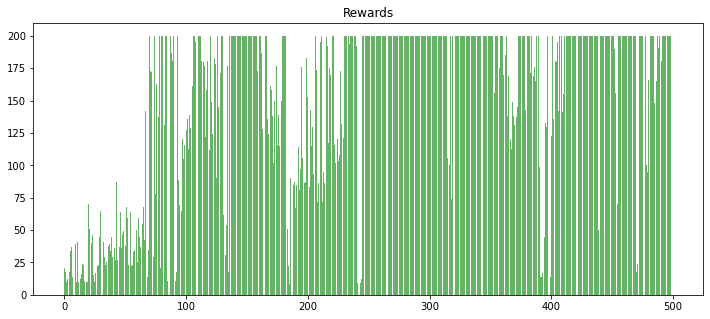

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.01
num_episodes = 500
gamma = 0.99

hidden_layer = 64

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        
        reward = Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        


qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        qnet_agent.optimize(state, action, new_state, reward, done )
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                '''
                  
                elapsed_time = time.time() - start_time
                #print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()


SOLVED! After 325 episodes 




Average reward: 163.86
Average reward (last 100 episodes): 186.45
Solved after 325 episodes


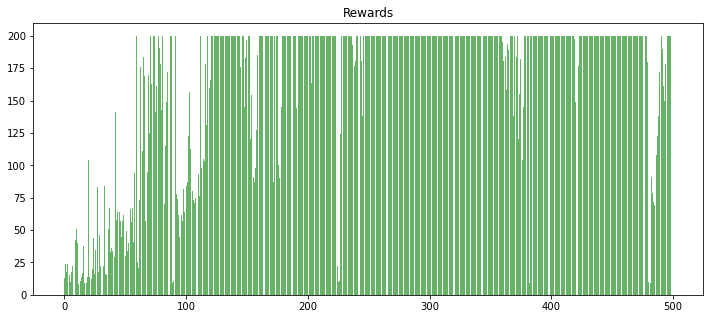

In [89]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: udemy
"""

import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.02
num_episodes = 500
gamma = 1

hidden_layer = 64

egreedy = 0.9
egreedy_final = 0
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        
        reward = Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        


qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        qnet_agent.optimize(state, action, new_state, reward, done )
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                '''
                  
                elapsed_time = time.time() - start_time
                #print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

SOLVED! After 114 episodes 
Solved after 114 episodes


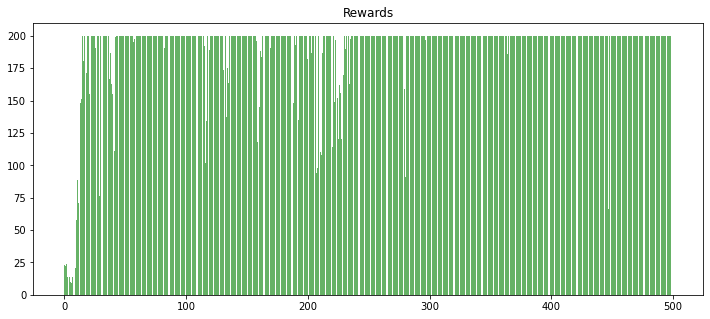

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.02
num_episodes = 500
gamma = 1

hidden_layer = 64

replay_mem_size = 50000
batch_size = 32

egreedy = 0.9
egreedy_final = 0
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)
        

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        new_state_values = self.nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

                '''

            break
        

#print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
#print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

SOLVED! After 213 episodes 
Solved after 213 episodes


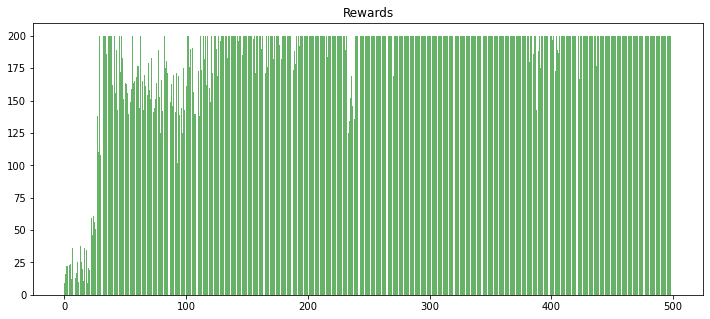

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.01
num_episodes = 500
gamma = 1

hidden_layer = 64

replay_mem_size = 50000
batch_size = 32

update_target_frequency = 100

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

clip_error = False

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)
        

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        new_state_values = self.target_nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1,1)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter += 1
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
                
                '''


            break
        

#print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
#print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

SOLVED! After 409 episodes 
Solved after 409 episodes


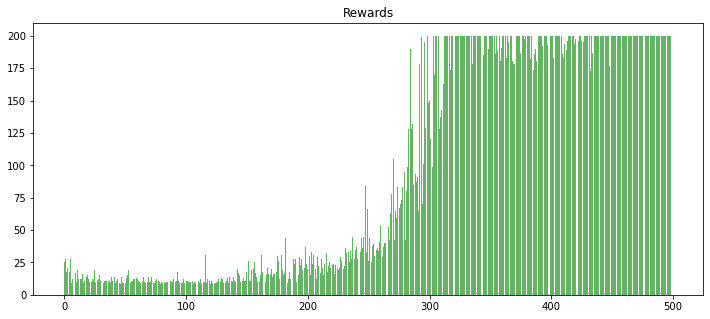

In [93]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: udemy
"""
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.001
num_episodes = 500
gamma = 0.9999

hidden_layer = 64

replay_mem_size = 50000
batch_size = 32

update_target_frequency = 500

double_dqn = True

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

clip_error = False

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)
        

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)


        if double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]  
            
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]
        
        
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1,1)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter += 1
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                  
                '''
                  
                elapsed_time = time.time() - start_time
                #print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

#print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
#print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

SOLVED! After 211 episodes 
Solved after 211 episodes


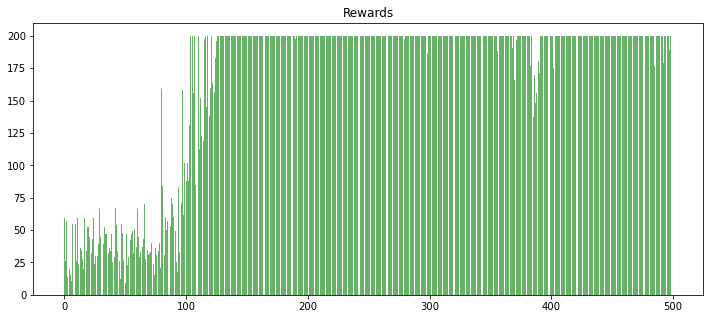

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.001
num_episodes = 500
gamma = 0.9999

hidden_layer = 64

replay_mem_size = 50000
batch_size = 32

double_dqn = True

update_target_frequency = 1500

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

clip_error = True

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)
        

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        
        self.advantage = nn.Linear(hidden_layer,number_of_outputs)
        self.value = nn.Linear(hidden_layer,1)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        
        output_advantage = self.advantage(output1)
        output_value = self.value(output1)
        
        output_final = output_value + output_advantage - output_advantage.mean()
        
        return output_final
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)


        if double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]  
            
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]
        
        
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                #print(param)
                param.grad.data.clamp_(-1,1)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter += 1
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                
                '''
                  
                elapsed_time = time.time() - start_time
                # print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

#print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
#print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

SOLVED! After 120 episodes 
Solved after 120 episodes


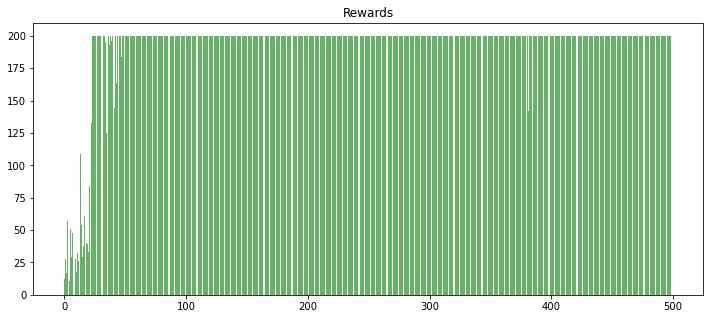

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time

import matplotlib.pyplot as plt

# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.001
num_episodes = 500
gamma = 1

hidden_layer = 64

replay_mem_size = 50000
batch_size = 32

update_target_frequency = 50

double_dqn = True

egreedy = 1
egreedy_final = 0.01
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

clip_error = False

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)
        
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        
        self.advantage = nn.Linear(hidden_layer,hidden_layer)
        self.advantage2 = nn.Linear(hidden_layer, number_of_outputs)
        
        self.value = nn.Linear(hidden_layer,hidden_layer)
        self.value2 = nn.Linear(hidden_layer,1)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        
        output_advantage = self.advantage(output1)
        output_advantage = self.activation(output_advantage)
        output_advantage = self.advantage2(output_advantage)
        
        output_value = self.value(output1)
        output_value = self.activation(output_value)
        output_value = self.value2(output_value)
        
        output_final = output_value + output_advantage - output_advantage.mean()

        return output_final
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)


        if double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]  
            
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]
        
        
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1,1)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter += 1
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                '''
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                '''
                elapsed_time = time.time() - start_time
                # print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

#print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
#print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

Episode finished. Reward: -20
Episode finished. Reward: -21
Episode finished. Reward: -20
Episode finished. Reward: -19
Episode finished. Reward: -20


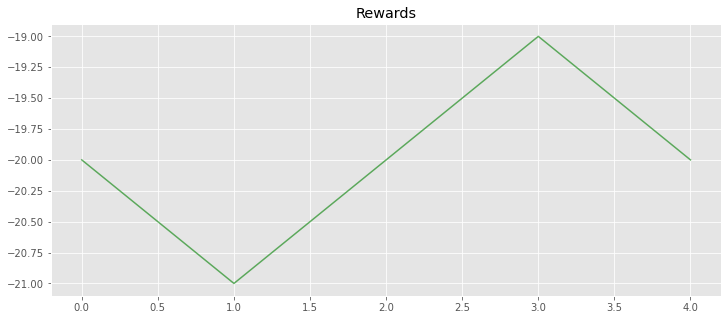

In [107]:
#import gym
import torch
import random

import matplotlib.pyplot as plt

from atari_wrappers import make_atari, wrap_deepmind

env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env)

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

num_episodes = 5

rewards_total = []

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    score = 0
    #for step in range(100):
    while True:
                
        action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        
        score += reward
        #print(new_state)
        #print(info)
        
        #env.render()
        
        if done:
            rewards_total.append(score)
            print("Episode finished. Reward: %i" % score )
            break
        

#print("Average reward: %.2f" % (sum(rewards_total)/num_episodes))
#print("Average reward (last 100 episodes): %.2f" % (sum(rewards_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.plot(rewards_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()